# Explore here

In [43]:
#Imports
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/vscode/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Loading the dataset 

In [44]:
df = pd.read_csv('/workspaces/JMP1ST-NPL/url_spam.csv')
df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [45]:
df.shape

(2999, 2)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [47]:
#Checking those instances where is_spam = True to identify how many spams we have and to get an insight of what is the relation between that link and spam being true
spam = df[df['is_spam']==True]
spam.sum()

url        https://briefingday.us8.list-manage.com/unsubs...
is_spam                                                  696
dtype: object

In [48]:
#Checking links content 
for i in range(3):
    print(spam['url'][i])

https://briefingday.us8.list-manage.com/unsubscribe
https://www.hvper.com/
https://briefingday.com/m/v4n3i4f3


We can see that we have 696 instances where spam = True. Later we will inspect if there is any relation between the link characters and the spams

In [49]:
#Checking for duplicates 
duplicates = df.duplicated().sum()

In [50]:
duplicates = df[df.duplicated(subset='url', keep=False)]
duplicates

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
4,https://briefingday.com/fan,True
22,https://www.technologyreview.com/innovators-un...,False
...,...,...
2971,https://www.cnbc.com/2020/06/29/stock-market-f...,False
2972,https://thehustle.co/account/,True
2973,https://thehustle.co/,True
2979,https://www.bloomberg.com/tosv2.html,True


In [51]:
#Grouping by URL and count how many unique values exist in is_spam to check for repeated url with differents labels (is_spam).
conflicts = df.groupby('url')['is_spam'].nunique()
conflicting_urls = conflicts[conflicts > 1]
print(conflicting_urls)

Series([], Name: is_spam, dtype: int64)


In order to not generate noise when training the model, the duplicated url will be dropped. 

In [52]:
df.drop_duplicates(subset='url', inplace=True)

In [53]:
df.shape

(2369, 2)

In [54]:
#Checking for imabalances 
df['is_spam'].value_counts(normalize=True)

is_spam
False    0.897003
True     0.102997
Name: proportion, dtype: float64

As we can see there is a high imbalance between False (90% of the total spam data) and True (10% of the total spam data). Therefore, we must inspect the best way to normalize this values distribution.

First let's search for patterns in the URL to have a better understanding of what counts as 'spam'

In [55]:
df[df['is_spam'] == True]['url'].sample(10, random_state=1)

862                 https://cariuma.com/pages/skimm-jun20
2890                      https://www.tldrnewsletter.com/
2826    https://numlock.substack.com/p/numlock-sunday-...
1475                             https://austinkleon.com/
1220    https://www.vox.com/2019/9/16/20861003/free-on...
2838    https://numlock.substack.com/p/numlock-sunday-...
777         https://www.voxmedia.com/legal/privacy-notice
2462                               https://www.float.com/
2298       https://www.dameproducts.com/pages/the-skimm-1
29                                  https://join1440.com/
Name: url, dtype: object

In [56]:
df[df['is_spam'] == False]['url'].sample(10, random_state=1)

882     https://www.wsj.com/articles/the-debt-is-soari...
1597    https://www.morningbrew.com/retail/stories/202...
1141    https://tim.blog/2019/07/15/psychedelics-micro...
718     https://www.theatlantic.com/health/archive/202...
2399    https://www.cnbc.com/2020/06/29/lululemon-to-a...
1587    https://www.reuters.com/article/us-l-oreal-whi...
2912    https://variety.com/2020/film/news/carl-reiner...
105     https://apnews.com/3ecbdd74c885b362661ed0f8c80...
756     https://www.cnbc.com/2020/06/23/millions-face-...
1663    https://blog.google/products/admanager/news-pu...
Name: url, dtype: object

Exploring the URLs revealed that spam links often come from lesser known domains and include promotional or newsletter related paths like /pages/, /p/, or keywords such as “join,” “free,” and “subscribe,” suggesting marketing or referral intent. In contrast, non spam links typically originate from trusted news or corporate domains with structured content paths like /articles/ or /products/. These patterns indicate that domain names, path components, and the presence of specific keywords could be solid features for distinguishing spam. 

Preprocessing the url's 

In [57]:
#Declaring a function to do all the pre processing 

#Stopwords
url_stopwords = {"http", "https", "www", "com", "html", "php", "net", "org", "www2"}

#Function
def pre_process_text(text):
    #Lowercase 
    text = text.lower()
    #Unwanted 'punct' marks
    text = re.sub(r"[^\w\s/-_.]", "", text)
    #Token
    tokens = re.split(r'\W+', text)
    #Removing empty strings
    tokens = [t for t in tokens if t]
    #Removing tokens
    tokens = [token for token in tokens if token not in url_stopwords]
    #Url's lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)


random_raw_url = df.sample(1).url.values[0]
print(f'Raw url: {random_raw_url}')

random_prepro_url =pre_process_text(random_raw_url)
print(f'Pre-processed url: {random_prepro_url}')

Raw url: https://deceuvel.nl/en/organisatie/
Pre-processed url: deceuvel nl en organisatie


The output of the pre_process_text function is a cleaned, well suited tokens for our model. Removing common words like 'www', 'https' and so on, we were able to deeply clean the text from repetitive and consistent words throug the df. 

In [58]:
#Applying the preprocess function to the url variable 
df['clean_url'] = df['url'].apply(pre_process_text)

In [59]:
df

,url,is_spam,clean_url
0,https://briefingday.us8.list-manage.com/unsubs...,True,briefingday us8 listmanage unsubscribe
1,https://www.hvper.com/,True,hvper
2,https://briefingday.com/m/v4n3i4f3,True,briefingday m v4n3i4f3
3,https://briefingday.com/n/20200618/m#commentform,False,briefingday n 20200618 mcommentform
4,https://briefingday.com/fan,True,briefingday fan
...,...,...,...
2993,https://www.theverge.com/2020/6/29/21306889/di...,False,theverge 2020 6 29 21306889 disneydeepfakeface...
2994,https://www.smartcitiesworld.net/news/news/dee...,False,smartcitiesworld news news deepfaketechnologyu...
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False,techcrunch 2019 07 04 anoptimisticviewofdeepfakes
2997,https://www.technologyreview.com/2019/12/20/13...,False,technologyreview 2019 12 20 131462 thisstartup...


In [60]:
#Checking for equally tokenized strings
df.duplicated(subset='clean_url').sum()

np.int64(6)

In [61]:
#Dropping those dups
df.drop_duplicates(subset=['clean_url'], inplace=True)

In [62]:
#Checking the shape
df.shape

(2363, 3)

Let's proceed to split the data 

In [63]:
#Defining X and Y 
X_train, X_test, y_train, y_test = train_test_split(df['clean_url'], df['is_spam'], test_size=0.2, random_state=42, stratify=df['is_spam'])

In [64]:
#Checking for proportions 
y_test.value_counts(normalize=True)

is_spam
False    0.896406
True     0.103594
Name: proportion, dtype: float64

In [65]:
#Checking for proportions 
y_train.value_counts(normalize=True)

is_spam
False    0.897354
True     0.102646
Name: proportion, dtype: float64

As we can see, stratified partitioning worked correctly as the proportions in both sets are nearly identical, meaning the model will train and be tested on similarly distributed data.

However, we can also clearly observe that there is a huge imbalance inside y ('is_spam'). Only about 1 in 10 URLs is spam and as we care the most for the recall performance on this model (False negatives are more dangerous) let's apply the SMOTE method to handle the imbalance. 

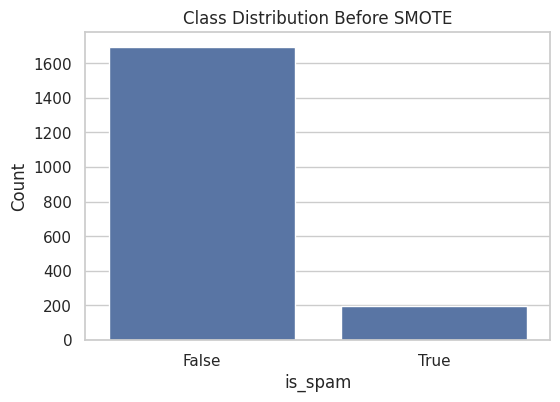

In [66]:
#Pre SMOTE class distribution (imbalance)

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("is_spam")
plt.ylabel("Count")
plt.show()

In [67]:
#Let's vectorize the url's before SMOTE ()
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)  # sparse matrix

In [68]:
#Applying SMOTE over the class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

In [69]:
#Vectorizing test set
X_test_vec = tfidf.transform(X_test)

In [70]:
#Checking the value counts the NEW y_train
y_train_resampled.value_counts(normalize=True)

is_spam
False    0.5
True     0.5
Name: proportion, dtype: float64

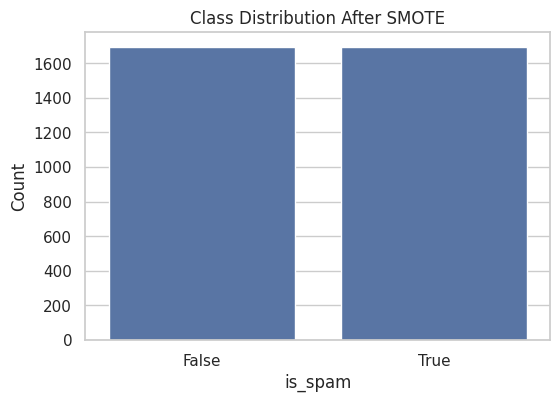

In [71]:
#Post SMOTE class distribution (Balanced)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("is_spam")
plt.ylabel("Count")
plt.show()

After applying SMOTE we can confirm that the class distribution is in conditions to train our model (SVC with default parameters)

In [72]:
#Instancing the model
svm_clf = SVC(random_state=42)

#Training on resampled data
svm_clf.fit(X_train_resampled, y_train_resampled)

#Predicting on test data
y_pred = svm_clf.predict(X_test_vec)

#Metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[368  56]
 [ 19  30]]
              precision    recall  f1-score   support

       False       0.95      0.87      0.91       424
        True       0.35      0.61      0.44        49

    accuracy                           0.84       473
   macro avg       0.65      0.74      0.68       473
weighted avg       0.89      0.84      0.86       473



The default SVM model performed well in identifying non-spam URLs, achieving high precision (95%) and good overall accuracy (84%). However, it struggled with detecting spam URLs, with lower precision (35%) and recall (61%), meaning it missed several spam cases and also had some false positives. This indicates that while the model is reliable at identifying safe links, it needs improvement in spotting spam, let's see how the recall for True behaves after tunning the hyperparameters. 

In [73]:
#Hyperparameter searching

#Defining parameters 
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

#Instancing GridSearchCV
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

#Results
print("Best params:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best recall score: 0.9988200589970502


Let's train and evaluate the model using the best Hyperparameters found.

In [74]:
#Instancing the SVM with best params
best_svcm = SVC(C=10, gamma='scale', kernel='linear', random_state=42)

#Training data
best_svcm.fit(X_train_resampled, y_train_resampled)

#Pred on test
y_pred1 = best_svcm.predict(X_test_vec)

print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

[[410  14]
 [ 17  32]]
              precision    recall  f1-score   support

       False       0.96      0.97      0.96       424
        True       0.70      0.65      0.67        49

    accuracy                           0.93       473
   macro avg       0.83      0.81      0.82       473
weighted avg       0.93      0.93      0.93       473



The optimized SVM model shows clear improvement over the default one. While the default model had an accuracy of 84% and a recall of 61% for the spam class, the tuned model reaches 93% accuracy and improves spam recall to 65%, which is crucial for detecting spam correctly. Precision for spam also increased significantly (from 35% to 70%), meaning fewer false positives. Overall, the optimized model is more balanced and better at identifying spam.

In [75]:
#Saving the best model 

joblib.dump(best_svcm, 'svm_spam_detector_model.joblib')

['svm_spam_detector_model.joblib']